(speed)=

# Python for Scientific Computing

In addition to what\'s in Anaconda, this lecture will need the following
libraries:

In [1]:
!pip install --upgrade quantecon

Requirement already up-to-date: quantecon in /usr/share/miniconda3/envs/qe-example/lib/python3.7/site-packages (0.4.8)


## Overview

Python is extremely popular for scientific computing, due to such
factors as

-   the accessible and flexible nature of the language itself,
-   the huge range of high quality scientific libraries now available,
-   the fact that the language and libraries are open source,
-   the popular Anaconda Python distribution, which simplifies
    installation and management of those libraries, and
-   the recent surge of interest in using Python for machine learning
    and artificial intelligence.

In this lecture we give a short overview of scientific computing in
Python, addressing the following questions:

-   What are the relative strengths and weaknesses of Python for these
    tasks?
-   What are the main elements of the scientific Python ecosystem?
-   How is the situation changing over time?

## Scientific Libraries

Let\'s briefly review Python\'s scientific libraries, starting with why
we need them.

### The Role of Scientific Libraries

One obvious reason we use scientific libraries is because they implement
routines we want to use.

For example, it\'s almost always better to use an existing routine for
root finding than to write a new one from scratch.

(For standard algorithms, efficiency is maximized if the community can
coordinate on a common set of implementations, written by experts and
tuned by users to be as fast and robust as possible.)

But this is not the only reason that we use Python\'s scientific
libraries.

Another is that pure Python, while flexible and elegant, is not fast.

So we need libraries that are designed to accelerate execution of Python
code.

As we\'ll see below, there are now Python libraries that can do this
extremely well.

### Python\'s Scientific Ecosystem

In terms of popularity, the big four in the world of scientific Python
libraries are

-   NumPy
-   SciPy
-   Matplotlib
-   Pandas

For us, there\'s another (relatively new) library that will also be
essential for numerical computing:

-   Numba

Over the next few lectures we\'ll see how to use these libraries.

But first, let\'s quickly review how they fit together.

-   NumPy forms the foundations by providing a basic array data type
    (think of vectors and matrices) and functions for acting on these
    arrays (e.g., matrix multiplication).
-   SciPy builds on NumPy by adding the kinds of numerical methods that
    are routinely used in science (interpolation, optimization, root
    finding, etc.).
-   Matplotlib is used to generate figures, with a focus on plotting
    data stored in NumPy arrays.
-   Pandas provides types and functions for empirical work (e.g.,
    manipulating data).
-   Numba accelerates execution via JIT compilation --- we\'ll learn
    about this soon.

## The Need for Speed

Now let\'s discuss execution speed.

Higher-level languages like Python are optimized for humans.

This means that the programmer can leave many details to the runtime
environment

-   specifying variable types
-   memory allocation/deallocation, etc.

The upside is that, compared to low-level languages, Python is typically
faster to write, less error-prone and easier to debug.

The downside is that Python is harder to optimize --- that is, turn
into fast machine code --- than languages like C or Fortran.

Indeed, the standard implementation of Python (called CPython) cannot
match the speed of compiled languages such as C or Fortran.

Does that mean that we should just switch to C or Fortran for
everything?

The answer is: No, no and one hundred times no!

(This is what you should say to the senior professor insisting that the
model needs to be rewritten in Fortran or C++.)

There are two reasons why:

First, for any given program, relatively few lines are ever going to be
time-critical.

Hence it is far more efficient to write most of our code in a high
productivity language like Python.

Second, even for those lines of code that *are* time-critical, we can
now achieve the same speed as C or Fortran using Python\'s scientific
libraries.

### Where are the Bottlenecks?

Before we learn how to do this, let\'s try to understand why plain
vanilla Python is slower than C or Fortran.

This will, in turn, help us figure out how to speed things up.

#### Dynamic Typing

Consider this Python operation

In [2]:
a, b = 10, 10
a + b

20

Even for this simple operation, the Python interpreter has a fair bit of
work to do.

For example, in the statement `a + b`, the interpreter has to know which
operation to invoke.

If `a` and `b` are strings, then `a + b` requires string concatenation

In [3]:
a, b = 'foo', 'bar'
a + b

'foobar'

If `a` and `b` are lists, then `a + b` requires list concatenation

In [4]:
a, b = ['foo'], ['bar']
a + b

['foo', 'bar']

(We say that the operator `+` is *overloaded* --- its action depends
on the type of the objects on which it acts)

As a result, Python must check the type of the objects and then call the
correct operation.

This involves substantial overheads.

#### Static Types

Compiled languages avoid these overheads with explicit, static types.

For example, consider the following C code, which sums the integers from
1 to 10

```c
#include <stdio.h>

int main(void) {
    int i;
    int sum = 0;
    for (i = 1; i <= 10; i++) {
        sum = sum + i;
    }
    printf("sum = %d\n", sum);
    return 0;
}
```

The variables `i` and `sum` are explicitly declared to be integers.

Hence, the meaning of addition here is completely unambiguous.

### Data Access

Another drag on speed for high-level languages is data access.

To illustrate, let\'s consider the problem of summing some data ---
say, a collection of integers.

#### Summing with Compiled Code

In C or Fortran, these integers would typically be stored in an array,
which is a simple data structure for storing homogeneous data.

Such an array is stored in a single contiguous block of memory

-   In modern computers, memory addresses are allocated to each byte
    (one byte = 8 bits).
-   For example, a 64 bit integer is stored in 8 bytes of memory.
-   An array of $n$ such integers occupies $8n$ **consecutive** memory
    slots.

Moreover, the compiler is made aware of the data type by the programmer.

-   In this case 64 bit integers

Hence, each successive data point can be accessed by shifting forward in
memory space by a known and fixed amount.

-   In this case 8 bytes

#### Summing in Pure Python

Python tries to replicate these ideas to some degree.

For example, in the standard Python implementation (CPython), list
elements are placed in memory locations that are in a sense contiguous.

However, these list elements are more like pointers to data rather than
actual data.

Hence, there is still overhead involved in accessing the data values
themselves.

This is a considerable drag on speed.

In fact, it\'s generally true that memory traffic is a major culprit
when it comes to slow execution.

Let\'s look at some ways around these problems.

## Vectorization

There is a clever method called **vectorization** that can be used to
speed up high level languages in numerical applications.

The key idea is to send array processing operations in batch to
pre-compiled and efficient native machine code.

The machine code itself is typically compiled from carefully optimized C
or Fortran.

For example, when working in a high level language, the operation of
inverting a large matrix can be subcontracted to efficient machine code
that is pre-compiled for this purpose and supplied to users as part of a
package.

This clever idea dates back to MATLAB, which uses vectorization
extensively.

Vectorization can greatly accelerate many numerical computations (but
not all, as we shall see).

Let\'s see how vectorization works in Python, using NumPy.

### Operations on Arrays

First, let\'s run some imports

In [5]:
import random
import numpy as np
import quantecon as qe

/usr/share/miniconda3/envs/qe-example/lib/python3.7/site-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)


Next let\'s try some non-vectorized code, which uses a native Python
loop to generate, square and then sum a large number of random
variables:

In [6]:
n = 1_000_000

In [7]:
%%time

y = 0      # Will accumulate and store sum
for i in range(n):
    x = random.uniform(0, 1)
    y += x**2

CPU times: user 527 ms, sys: 0 ns, total: 527 ms
Wall time: 527 ms


The following vectorized code achieves the same thing.

In [8]:
%%time

x = np.random.uniform(0, 1, n)
y = np.sum(x**2)

CPU times: user 11.1 ms, sys: 6.95 ms, total: 18.1 ms
Wall time: 17.8 ms


As you can see, the second code block runs much faster. Why?

The second code block breaks the loop down into three basic operations

1.  draw `n` uniforms
2.  square them
3.  sum them

These are sent as batch operators to optimized machine code.

Apart from minor overheads associated with sending data back and forth,
the result is C or Fortran-like speed.

When we run batch operations on arrays like this, we say that the code
is *vectorized*.

Vectorized code is typically fast and efficient.

It is also surprisingly flexible, in the sense that many operations can
be vectorized.

The next section illustrates this point.

(ufuncs)=

### Universal Functions

Many functions provided by NumPy are so-called *universal functions*
--- also called
[ufuncs](https://docs.scipy.org/doc/numpy/reference/ufuncs.html).

This means that they

-   map scalars into scalars, as expected
-   map arrays into arrays, acting element-wise

For example, `np.cos` is a ufunc:

In [9]:
np.cos(1.0)

0.5403023058681398

In [10]:
np.cos(np.linspace(0, 1, 3))

array([1.        , 0.87758256, 0.54030231])

By exploiting ufuncs, many operations can be vectorized.

For example, consider the problem of maximizing a function $f$ of two
variables $(x,y)$ over the square $[-a, a] \times [-a, a]$.

For $f$ and $a$ let\'s choose

$$
f(x,y) = \frac{\cos(x^2 + y^2)}{1 + x^2 + y^2}
\quad \text{and} \quad
a = 3
$$

Here\'s a plot of $f$

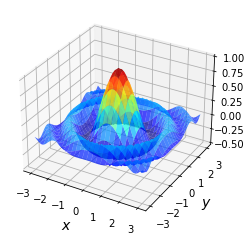

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline
from mpl_toolkits.mplot3d.axes3d import Axes3D
from matplotlib import cm

def f(x, y):
    return np.cos(x**2 + y**2) / (1 + x**2 + y**2)

xgrid = np.linspace(-3, 3, 50)
ygrid = xgrid
x, y = np.meshgrid(xgrid, ygrid)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(x,
                y,
                f(x, y),
                rstride=2, cstride=2,
                cmap=cm.jet,
                alpha=0.7,
                linewidth=0.25)
ax.set_zlim(-0.5, 1.0)
ax.set_xlabel('$x$', fontsize=14)
ax.set_ylabel('$y$', fontsize=14)
plt.show()

To maximize it, we\'re going to use a naive grid search:

1.  Evaluate $f$ for all $(x,y)$ in a grid on the square.
2.  Return the maximum of observed values.

The grid will be

In [12]:
grid = np.linspace(-3, 3, 1000)

Here\'s a non-vectorized version that uses Python loops.

In [13]:
%%time

m = -np.inf

for x in grid:
    for y in grid:
        z = f(x, y)
        if z > m:
            m = z

CPU times: user 4.36 s, sys: 509 µs, total: 4.36 s
Wall time: 4.35 s


And here\'s a vectorized version

In [14]:
%%time

x, y = np.meshgrid(grid, grid)
np.max(f(x, y))

CPU times: user 32 ms, sys: 20.1 ms, total: 52.1 ms
Wall time: 51.7 ms


0.9999819641085747

In the vectorized version, all the looping takes place in compiled code.

As you can see, the second version is **much** faster.

(We\'ll make it even faster again later on, using more scientific
programming tricks.)

(numba-p_c_vectorization)=

## Beyond Vectorization

At its best, vectorization yields fast, simple code.

However, it\'s not without disadvantages.

One issue is that it can be highly memory-intensive.

For example, the vectorized maximization routine above is far more
memory intensive than the non-vectorized version that preceded it.

This is because vectorization tends to create many intermediate arrays
before producing the final calculation.

Another issue is that not all algorithms can be vectorized.

In these kinds of settings, we need to go back to loops.

Fortunately, there are alternative ways to speed up Python loops that
work in almost any setting.

For example, in the last few years, a new Python library called [Numba]
(http://numba.pydata.org/) has appeared that solves
the main problems with vectorization listed above.

It does so through something called **just in time (JIT) compilation**,
which can generate extremely fast and efficient code.

We\'ll learn how to use Numba [soon](numba).